# ================================
# SMS Spam Classification (TF-IDF + NB + LR + SVM)
# ================================

# 1) Imports

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, f1_score
)

# 2) Load & basic clean

In [189]:
df = pd.read_csv("spam.csv", encoding="latin-1")[['v1','v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (5572, 2)


,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# 3) Train / test split

In [191]:
X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'],
    test_size=0.20, random_state=42, stratify=df['label']
)

In [192]:
# 4) TF-IDF features (unigram + bigram works well for spam)
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (4457, 5000)


# 5) Helper: metric summary for a prediction vector


In [194]:
def metric_row(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    # report spam (class 1) metrics explicitly since that's the tricky class
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0,1])
    return {
        "model": model_name,
        "accuracy": acc,
        "ham_precision": p[0], "ham_recall": r[0], "ham_f1": f1 if isinstance(f1, float) else f1,  # unused, kept for clarity
        "spam_precision": p[1], "spam_recall": r[1], "spam_f1": precision_recall_fscore_support(y_true, y_pred, average='binary')[2]
    }

# 6) Multinomial Naive Bayes

In [196]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

print("\n=== Multinomial Naive Bayes ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=["Ham","Spam"]))


=== Multinomial Naive Bayes ===
Accuracy: 0.9713004484304932
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.99      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



# 7) Logistic Regression (class-weight balanced) + threshold tuning for best F1

In [224]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr.fit(X_train_tfidf, y_train)

y_pred_lr_default = lr.predict(X_test_tfidf)
y_proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]

# Search thresholds from 0.1 to 0.9 in steps of 0.05
thresholds = np.arange(0.1, 0.9, 0.05)
best_thresh, best_f1 = 0.5, 0.0

print("\n=== Logistic Regression Threshold Tuning ===")
for t in thresholds:
    y_pred_t = (y_proba_lr >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    print(f"Threshold={t:.2f}, F1={f1:.4f}")
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print(f"\n✅ Best Threshold = {best_thresh:.2f} with F1 = {best_f1:.4f}")

# Predictions with best threshold
y_pred_lr_best = (y_proba_lr >= best_thresh).astype(int)

print("\n=== Logistic Regression (default threshold=0.5) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_default))
print(classification_report(y_test, y_pred_lr_default, target_names=["Ham","Spam"]))

print(f"\n=== Logistic Regression (best threshold={best_thresh:.2f}) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_best))
print(classification_report(y_test, y_pred_lr_best, target_names=["Ham","Spam"]))


=== Logistic Regression Threshold Tuning ===
Threshold=0.10, F1=0.3458
Threshold=0.15, F1=0.5034
Threshold=0.20, F1=0.6503
Threshold=0.25, F1=0.7824
Threshold=0.30, F1=0.8452
Threshold=0.35, F1=0.9010
Threshold=0.40, F1=0.9211
Threshold=0.45, F1=0.9396
Threshold=0.50, F1=0.9428
Threshold=0.55, F1=0.9338
Threshold=0.60, F1=0.9296
Threshold=0.65, F1=0.9214
Threshold=0.70, F1=0.9137
Threshold=0.75, F1=0.9097
Threshold=0.80, F1=0.8930
Threshold=0.85, F1=0.8494

✅ Best Threshold = 0.50 with F1 = 0.9428

=== Logistic Regression (default threshold=0.5) ===
Accuracy: 0.9847533632286996
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       966
        Spam       0.95      0.94      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.98      0.98      0.98      1115


=== Logistic Regression (best threshold=0.50) ===
Accuracy: 0.9847533632286996
       

# 8) Linear SVM (LinearSVC)
# Note: LinearSVC doesn't provide predict_proba, but it's very strong for text.
# Set dual=True when n_features > n_samples (common with TF-IDF + bigrams).

In [201]:
svm = LinearSVC(dual=True)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

In [202]:
print("\n=== Linear SVM (LinearSVC) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=["Ham","Spam"]))


=== Linear SVM (LinearSVC) ===
Accuracy: 0.9838565022421525
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



# 9) Compare models in a small table

In [204]:
rows = []
rows.append(metric_row(y_test, y_pred_nb,         "Naive Bayes"))
rows.append(metric_row(y_test, y_pred_lr_default, "LogReg (th=0.50)"))
rows.append(metric_row(y_test, y_pred_lr_best,    f"LogReg (th={best_t:.2f})"))
rows.append(metric_row(y_test, y_pred_svm,        "LinearSVC"))

summary = pd.DataFrame(rows)[["model","accuracy","spam_precision","spam_recall","spam_f1"]]
display(summary.sort_values(by="spam_f1", ascending=False).reset_index(drop=True))

,model,accuracy,spam_precision,spam_recall,spam_f1
0,LogReg (th=0.50),0.984753,0.945946,0.939597,0.942761
1,LogReg (th=0.50),0.984753,0.945946,0.939597,0.942761
2,LinearSVC,0.983857,0.985185,0.892617,0.936620
3,Naive Bayes,0.971300,0.991597,0.791946,0.880597


# 10) Confusion matrix heatmap for the best performer (by spam F1)

In [206]:
best_idx = summary['spam_f1'].idxmax()
best_name = summary.loc[best_idx, 'model']

if "Naive Bayes" in best_name:
    cm = confusion_matrix(y_test, y_pred_nb)
elif "LinearSVC" in best_name:
    cm = confusion_matrix(y_test, y_pred_svm)
elif "th=" in best_name:
    cm = confusion_matrix(y_test, y_pred_lr_best)
else:
    cm = confusion_matrix(y_test, y_pred_lr_default)

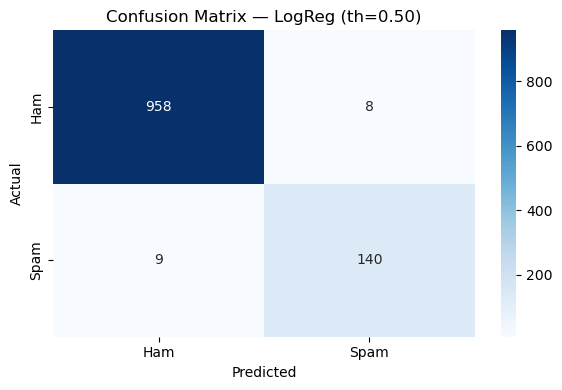

In [207]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()